In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Activation, Input, Embedding, Reshape, MaxPooling1D, Conv1D
from keras.layers import LSTM, GRU, Conv1D
from keras.layers import Dropout, BatchNormalization, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.activations import sigmoid
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.callbacks import TensorBoard
import numpy as np
import random
import sys
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
with open('data/sampled.json', encoding='utf-8') as f:
    json_data = json.load(f)

In [3]:
len(json_data)

93835

In [4]:
original_sentences = list(json_data.keys())
fake_sentences = []
for x in json_data.values():
    fake_sentences.extend(x)

print('original_sentences:\t', len(original_sentences))
print('fake_sentences:\t', len(fake_sentences))

print('mean len of original sentences:\t', np.mean([len(x) for x in original_sentences]), 'chars')
print('mean len of fake sentences:\t', np.mean([len(x) for x in fake_sentences]), 'chars')

original_sentences:	 93835
fake_sentences:	 837562
mean len of original sentences:	 78.7067618692 chars
mean len of fake sentences:	 36.7815146819 chars


In [5]:
from libs.utils import load_transformer

transformer = load_transformer('models/shm_c1')

chars = transformer.tokens
char_cats = len(chars)
print('total chars:', char_cats)

total chars: 42


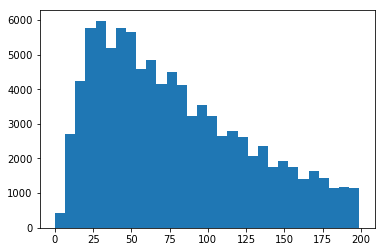

In [6]:
a = plt.hist([len(x) for x in original_sentences], bins=30)

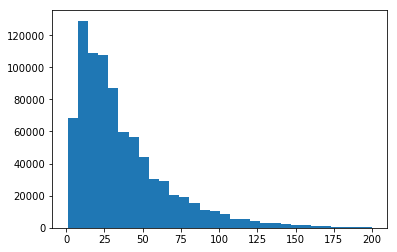

In [7]:
a = plt.hist([len(x) for x in fake_sentences], bins=30)

In [8]:
max_len = 200

In [9]:
from libs.utils import pad

# transform text into sequence of indices
pad_idx = char_cats
original_indexes = np.array([pad(transformer.transform(sent), max_len, pad_idx) for sent in original_sentences])
fake_indexes     = np.array([pad(transformer.transform(sent), max_len, pad_idx) for sent in fake_sentences])

In [10]:
n_batches = (len(original_indexes) + len(fake_indexes)) // 300
batch_size = 16

In [11]:
from libs.utils import split_data_into_correct_batches
X, y = split_data_into_correct_batches(dostoewskij_indexes, non_dostoewskij_indexes, 
                                       n_batches, max_len, make_equal_folding=True)

In [12]:
X.shape

(3104, 200)

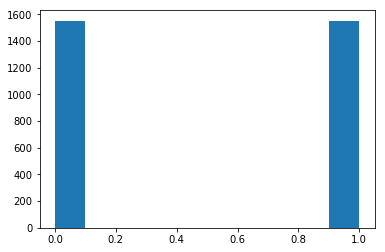

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

a = plt.hist(y)

In [14]:
from keras.losses import sparse_categorical_crossentropy

def create_char_rnn():
    inp = Input(shape=(max_len,), dtype="int32")
    v = Embedding(char_cats+1, int(char_cats / 1.5))(inp)
    h1 = GRU(256, stateful=False, return_sequences=True, unroll=True, implementation=0)(v)
    h2 = GRU(256, stateful=False, return_sequences=False, unroll=True, implementation=0)(h1)
    y = Dense(2, activation='softmax')(h2)
    model = Model(inp, y, name="char_rnn")
    model.compile(optimizer=RMSprop(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
    return model

In [15]:
def create_cnn():
    inp = Input(shape=(max_len,), dtype="int32")
    v = Embedding(char_cats+1, int(char_cats / 1.5))(inp)
    x = Conv1D(128, kernel_size=8, activation='relu', padding='same')(v) # None, 200, 64
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(4, padding='same')(x) # None, 50, 64

    x = Conv1D(128, kernel_size=8, activation='relu', padding='same')(x) # None, 50, 128
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(2, padding='same')(x) # None, 25, 128

    x = Conv1D(256, kernel_size=8, activation='relu', padding='same')(x) # None, 25, 256
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(5, padding='same')(x) # None, 5, 256

    h = Flatten()(x) # None, 5*256
    y = Dense(2, activation='softmax')(h) # None, 512
    model = Model(inp, y, name="char_cnn")
    model.compile(optimizer=RMSprop(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
    return model

In [16]:
rnn = create_cnn()

In [17]:
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 28)           1204      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          28800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           131200    
__________

In [18]:
history = rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1)

Epoch 1/1
3104/3104 [==============================] - 7s - loss: 1.0577 - acc: 0.6424     


In [22]:
from time import clock

n_epochs = 6
n_batches = (len(original_indexes) + len(fake_indexes)) // 15
histories = []

lens = [max_len - np.mean([list(x).count(42) for x in fake_indexes])]
sizes = [len(fake_indexes)]

for epoch in range(n_epochs):
    if epoch == 0:
        X, y = split_data_into_correct_batches(original_indexes, fake_indexes, make_equal_folding=True)
    elif epoch % 3 == 0:
        t = clock()
        probs = rnn.predict(fake_indexes)[:, 0]
        bool_ind = np.random.uniform(0., 1., probs.shape) < probs
        indexes = np.arange(bool_ind.shape[0])[bool_ind]

        print('epoch', epoch, '- deleting took', clock() - t, 'sec')
        X, y = split_data_into_correct_batches(original_indexes, fake_indexes[indexes], make_equal_folding=True)
        lens.append(max_len - np.mean([list(x).count(42) for x in fake_indexes[indexes]]))
        sizes.append(len(indexes))
    histories.append(rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1))

Epoch 1/1
62093/62093 [==============================] - 59s - loss: 0.4257 - acc: 0.7944    
Epoch 1/1
62093/62093 [==============================] - 58s - loss: 0.4167 - acc: 0.8013    
Epoch 1/1
62093/62093 [==============================] - 58s - loss: 0.4086 - acc: 0.8061    
epoch 3 - deleting took 140.0255885735371 sec
Epoch 1/1
62093/62093 [==============================] - 59s - loss: 0.5563 - acc: 0.6890    
Epoch 1/1
62093/62093 [==============================] - 59s - loss: 0.5421 - acc: 0.7009    
Epoch 1/1
62093/62093 [==============================] - 59s - loss: 0.5321 - acc: 0.7122    


In [23]:
lens

[36.781514681898187, 60.877944271825186]

In [ ]:
%debug

In [ ]:
rnn.save('models/discriminator_believability_rnn_model.h5')